# Stack Overflow Tag Prediction 1: Data cleaning and exploration

## Description

Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.
The goal of this project is to predict as many tags as possible with high precision and recall. Incorrect tags could impact user experience on StackOverflow.
To do so a selected sample of stackoverflow questions is downloaded from 
https://data.stackexchange.com/stackoverflow/query/new

using the following SQL query:

"SELECT 
	TOP 50000 ViewCount,
    CreationDate,
    Title,
    Body,
    Tags,
    Score,
    CommentCount,
    AnswerCount,
    FavoriteCount
    
FROM Posts
WHERE 
    FavoriteCount > 10
    AND AnswerCount > 1
    AND Score > 100
ORDER BY Score DESC "

In this notebook data are cleaned and a general descriptive analysis is carried out

## 1. Import data and Python libraries

In [1]:

import pandas as pd
from bs4 import BeautifulSoup
import nltk, re, pprint
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from collections import defaultdict 
from nltk.corpus import wordnet as wn
from itertools import chain
from difflib import get_close_matches as gcm
import re
from textblob import TextBlob, Word
import time
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from matplotlib import pyplot as plt
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS


In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/marco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/marco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df_raw = pd.read_csv('/home/marco/Documents/OC_Machine_learning/section_5/tags_stackoverflow/data-output/QueryResults.csv', parse_dates=['CreationDate']) #import raw data from the csv obtained by SQL query
df_raw.Date=pd.to_datetime(df_raw.CreationDate) # set creation date as date and time object

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


### 1.1 Dataframe Fields Explaination

In [4]:
print(df_raw.shape)
df_raw.head()

(37175, 9)


,ViewCount,CreationDate,Title,Body,Tags,Score,CommentCount,AnswerCount,FavoriteCount
0,1483128,2012-06-27 13:51:36,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,<java><c++><performance><optimization><branch-...,24320,22,26,10983
1,8547399,2009-05-29 18:09:14,How do I undo the most recent local commits in...,<p>I accidentally committed the wrong files to...,<git><version-control><git-commit><undo><pre-c...,20895,13,83,6776
2,8115583,2010-01-05 01:12:15,How do I delete a Git branch locally and remot...,<p>I want to delete a branch both locally and ...,<git><version-control><git-branch><git-push><g...,16826,6,40,5357
3,2782271,2008-11-15 09:51:09,What is the difference between 'git pull' and ...,<p>What are the differences between <code>git ...,<git><version-control><git-pull><git-fetch>,11833,9,35,2333
4,2783219,2009-01-25 15:25:19,What is the correct JSON content type?,"<p>I've been messing around with <a href=""http...",<json><http-headers><content-type>,10204,0,36,1446


Dataset contains 37175 rows. The columns in the table are:

Viewcount - amount of views

CreationDate - date question was added

Title - The question's title

Body - The body of the question

Tags - The tags associated with the question in a space-seperated format 

Score - Note based on user votes

CommentCount - amount of comments

AnswerCount - amount of answers

FavoriteCount - amount of favorites

## 2. Text processing: remove numbers, special characters,lemmatization 

In [5]:
# Define a time counter function to test the algorythm performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

### 2.1 Tags: get rid of angle brackets

In [6]:
pattern = "<(.*?)>" # indicate to regex the pattern for angle brackets: < >
df_raw['Tags_clean'] = [re.findall(pattern, text) for text in df_raw['Tags'] ] # get text within the square brackets as list entries

### 2.2 Body : get text from html and clean it

In [7]:
# get text from html using Beautifulsoup
process_time_starts()
df_raw['Bodytext'] = [BeautifulSoup(text).get_text() for text in df_raw['Body'] ] # get text from html body
time_elapsed()

The process took: 0hour:0min:18sec


In [8]:
nlp = spacy.load('en_core_web_sm') # load SpaCy and add some nonsensical characters to stopwords
customize_stop_words = ['y','b','x','s']

for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

print(nlp.vocab["s"].is_stop) # verify

True


Cleaning decorator

In [9]:
def clean(list):    
     
    def lowering(list):
            lowerlist= list.str.lower()
            return lowerlist
    
    list= lowering(list)    
    
    def stopremove(list): # remove stopwords from the Body         
            stoplist = list.apply(lambda x: [item for item in word_tokenize(x) if item not in STOP_WORDS]) # remove stopwords from tokens using SpaCy list
            return stoplist
    list = stopremove(list)
    
         
    def number_remove(list): # Decorator to Remove all digits from a list of strings 
            pattern1 = '[0-9]'
            nonumlist = [re.sub(pattern1, '', i) for i in list] 
            return nonumlist
        
    list= [number_remove(text) for text in list ]
    
    def punct_remove(list): # remove punctuation from the Body 
            pattern2 = "[?.!/;:']"
            nopunctlist = [re.sub(pattern2, '', i) for i in list] 
            return nopunctlist
        
    list = [punct_remove(text) for text in list ]
    
    def char_remove(list): # remove special character from the Body 
            pattern3 = "[<>\@*=]"
            nocharlist = [re.sub(pattern3, '', i) for i in list] 
            return nocharlist
        
    list = [char_remove(text) for text in list ]

      
    def lemma(list): # Lemmatization of cleaned body
        sentence = ' '.join(list) # get a string out of the list in the column cell so that lemmatization can be run
        sent = TextBlob(sentence)
        tag_dict = {"J": 'a', 
                    "N": 'n', 
                    "V": 'v', 
                    "R": 'r'}
        words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
        lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
        return lemmatized_list
    
    list = [lemma(text) for text in list ] # lemmatize  
    
    return list

In [10]:
# clean and lemmatize the text
process_time_starts()
df_raw['Lemma'] = clean(df_raw['Bodytext'])
print('Text cleaning and lemmatization done!')
time_elapsed()

Text cleaning and lemmatization done!
The process took: 0hour:4min:32sec


In [11]:
df_raw['Lemma'] #verify the text is now clean

0        [piece, c++, code, show, peculiar, behavior, s...
1        [accidentally, commit, wrong, file, git, push,...
2        [want, delete, branch, locally, remotely, fail...
3                      [difference, git, pull, git, fetch]
4        [mess, json, time, push, text, hurt, anybody, ...
                               ...                        
37170    [comparison, output, reveals, difference, user...
37171    [node-inspector, grunt, application, debugging...
37172    [app, run, press, home, button, app, go, backg...
37173    [work, lot, datetime, class, recently, run, th...
37174    [work, docker, want, mount, dynamic, folder, c...
Name: Lemma, Length: 37175, dtype: object

In [12]:
cleanfeatures = ['ViewCount', 'CreationDate','Body', 'Lemma','Tags_clean', 'Score', 'CommentCount', 'AnswerCount', 'FavoriteCount']
df_clean = df_raw[cleanfeatures] 

In [13]:
df_clean.rename(columns={'Body_lemma':'body', 'Tags_clean':'tags'},inplace=True)

df_clean.head()

/home/marco/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ViewCount,CreationDate,Body,Lemma,tags,Score,CommentCount,AnswerCount,FavoriteCount
0,1483128,2012-06-27 13:51:36,<p>Here is a piece of C++ code that shows some...,"[piece, c++, code, show, peculiar, behavior, s...","[java, c++, performance, optimization, branch-...",24320,22,26,10983
1,8547399,2009-05-29 18:09:14,<p>I accidentally committed the wrong files to...,"[accidentally, commit, wrong, file, git, push,...","[git, version-control, git-commit, undo, pre-c...",20895,13,83,6776
2,8115583,2010-01-05 01:12:15,<p>I want to delete a branch both locally and ...,"[want, delete, branch, locally, remotely, fail...","[git, version-control, git-branch, git-push, g...",16826,6,40,5357
3,2782271,2008-11-15 09:51:09,<p>What are the differences between <code>git ...,"[difference, git, pull, git, fetch]","[git, version-control, git-pull, git-fetch]",11833,9,35,2333
4,2783219,2009-01-25 15:25:19,"<p>I've been messing around with <a href=""http...","[mess, json, time, push, text, hurt, anybody, ...","[json, http-headers, content-type]",10204,0,36,1446


## 3. Dataframe exploration

### 3.1 Most popular tags

In [14]:
df_clean['taglist'] = [' '.join(map(str, l)) for l in df_clean['tags']] # transform lists to strings to be able to run wordcloud
df_clean['lemmalist'] = [' '.join(map(str, l)) for l in df_clean['Lemma']]

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# Flatten the tags column to a long list of words
def unnest(df, col, reset_index=False):
    import pandas as pd
    col_flat = pd.DataFrame([[i, x] 
                       for i, y in df[col].apply(list).iteritems() 
                           for x in y], columns=['I', col])
    col_flat = col_flat.set_index('I')
    df = df.drop(col, 1)
    df = df.merge(col_flat, left_index=True, right_index=True)
    if reset_index:
        df = df.reset_index(drop=True)
    return df[col]

tagscol = unnest(df_clean, 'tags') # apply the decorator to the tags column of the clean dataframe

df_tags = pd.DataFrame({'tags': tagscol}).reset_index() #create a new dataframe out of the flattened list

In [16]:
df_tagfreq = df_tags.tags.value_counts().reset_index() # create a new dataframe with value counts for each tag
df_tagfreq.rename(columns={'index':'tag', 'tags':'count'},inplace=True)
df_tagfreq['frequency (%)'] = (df_tagfreq['count']/len(tagscol))*100 # estimate frequency from counts

print(df_tagfreq.shape) # how many tags do we have?
df_tagfreq.head()

(8578, 3)


,tag,count,frequency (%)
0,javascript,3919,3.477960
1,python,3576,3.173561
2,java,3434,3.047541
3,c#,2742,2.433418
4,android,2450,2.174280


[]

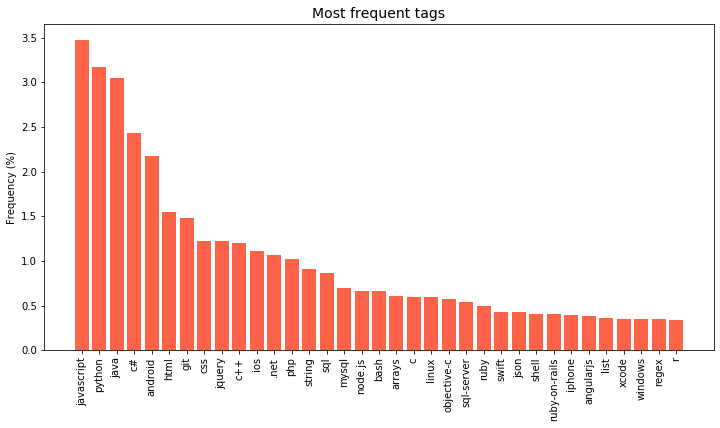

In [17]:
plt.figure(figsize=(12, 6))

plt.bar(df_tagfreq['tag'].iloc[0:35],df_tagfreq['frequency (%)'].iloc[0:35], color = 'tomato') #cases by region
plt.title('Most frequent tags', fontsize = 14)
plt.ylabel('Frequency (%)')
plt.xticks(rotation=90)
plt.plot()

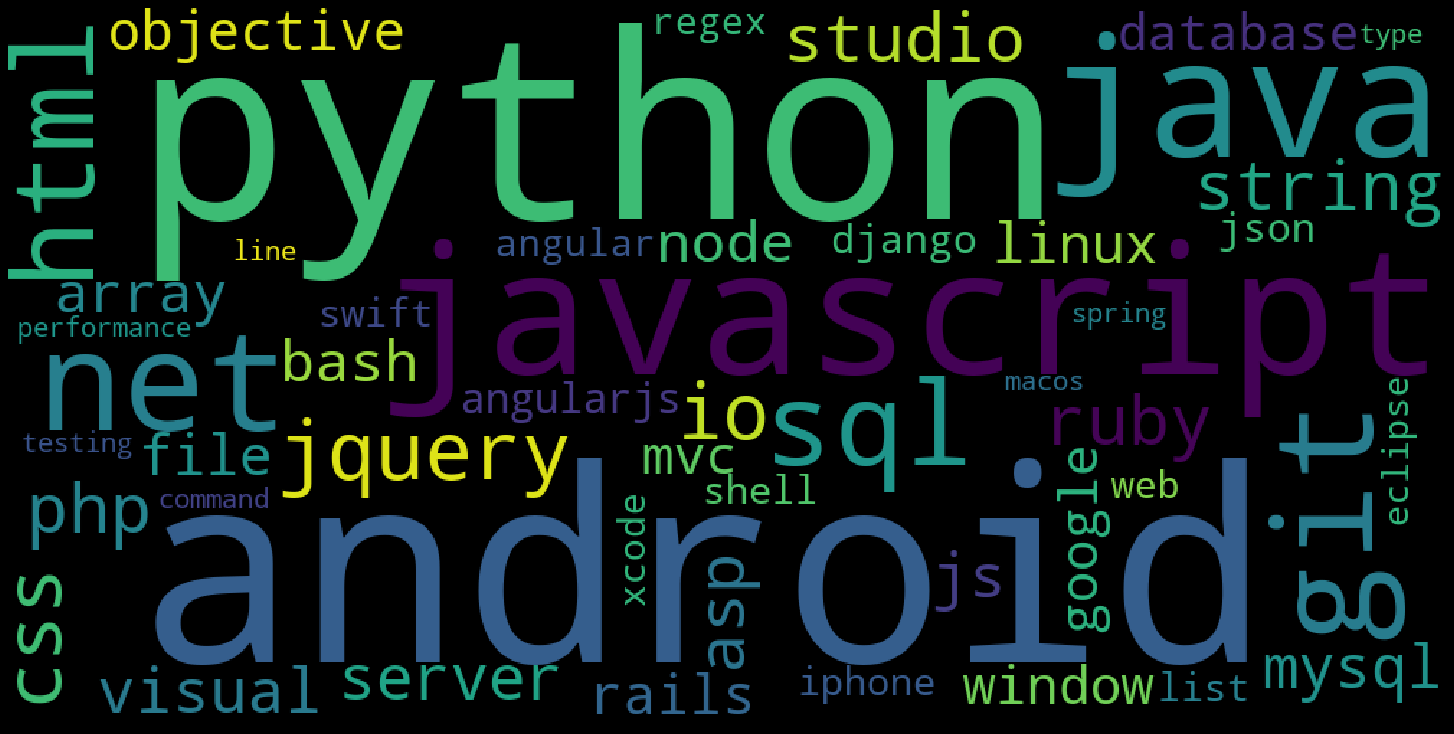

In [18]:
soup = ' '.join(df_tags['tags']) 
#wordcloud = WordCloud().generate()

wordcloud = WordCloud(width=1000, height=500,max_words=50, collocations=False)
wordcloud.generate(soup)
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 3.2 Body text corresponding to the three most popular tags

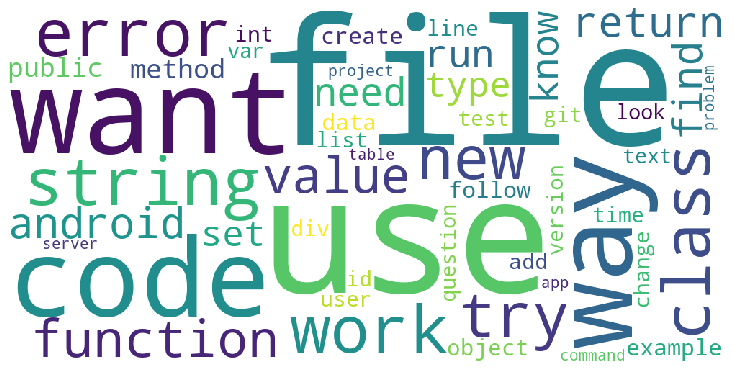

In [19]:
# wordcloud for the whole body text
soup = ' '.join(df_clean['lemmalist'])
wordcloud = WordCloud(background_color="white", width=1000, height=500,max_words=50, collocations=False).generate(soup)
plt.figure(figsize=(10,5),facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Creation of three subsets of the clean dataframe, one for each of the most popular tags ('javascript', 'java','python')

In [20]:
# javascript
df_js = df_clean[df_clean['taglist'].str.match('javascript')]
# java
df_java = df_clean[df_clean['taglist'].str.match('java')] # this will include also "javascript" and this term has to be filtered out
df_java = df_java[~df_java["taglist"].str.contains('javascript')] # for this I use the invert (~) operator (which acts like a not for boolean data)
# python
df_py = df_clean[df_clean['taglist'].str.match('python')]

Word frequency counts from each dataframe

In [21]:
jsbody = ' '.join(df_js['lemmalist']) # get a list of strings from lemma column of the javascript tag dataframe
# Converting string to list 
js_wordList = re.sub("[^\w]", " ",  jsbody).split() 
df_jscount = pd.DataFrame({'js': js_wordList}).reset_index() #create a new dataframe out of the flattened list
df_jsfreq = df_jscount.js.value_counts().reset_index() # create a new dataframe with value counts for each js
df_jsfreq.rename(columns={'index':'word', 'js':'count'},inplace=True)
df_jsfreq['frequency (%)'] = (df_jsfreq['count']/len(js_wordList))*100 # estimate frequency from counts

In [22]:
javabody = ' '.join(df_java['lemmalist']) # get a list of strings from lemma column of the javascript tag dataframe
# Converting string to list 
java_wordList = re.sub("[^\w]", " ",  javabody).split() 
df_javacount = pd.DataFrame({'java': java_wordList}).reset_index() #create a new dataframe out of the flattened list
df_javafreq = df_javacount.java.value_counts().reset_index() # create a new dataframe with value counts for each java
df_javafreq.rename(columns={'index':'word', 'java':'count'},inplace=True)
df_javafreq['frequency (%)'] = (df_javafreq['count']/len(java_wordList))*100 # estimate frequency from count

In [23]:
pybody = ' '.join(df_py['lemmalist']) # get a list of strings from lemma column of the pyscript tag dataframe
# Converting string to list 
py_wordList = re.sub("[^\w]", " ",  pybody).split() 
df_pycount = pd.DataFrame({'py': py_wordList}).reset_index() #create a new dataframe out of the flattened list
df_pyfreq = df_pycount.py.value_counts().reset_index() # create a new dataframe with value counts for each py
df_pyfreq.rename(columns={'index':'word', 'py':'count'},inplace=True)
df_pyfreq['frequency (%)'] = (df_pyfreq['count']/len(py_wordList))*100 # estimate frequency from counts

Wordcloud for each dataframe

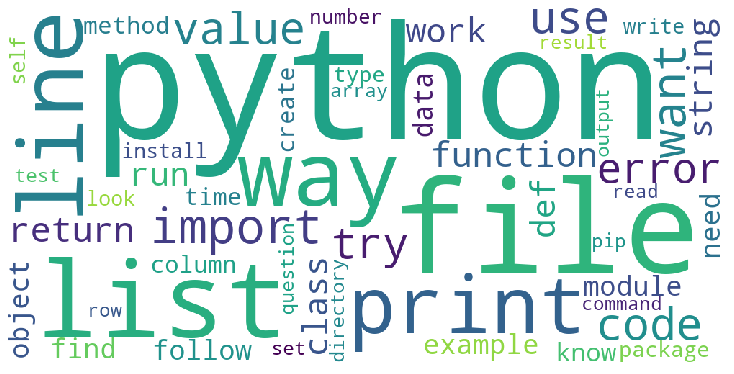

In [24]:
# wordcloud for words in the text body associated to tag: python
soup = ' '.join(df_py['lemmalist'])
wordcloud = WordCloud(background_color="white", width=1000, height=500,max_words=50, collocations=False).generate(soup)
plt.figure(figsize=(10,5),facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

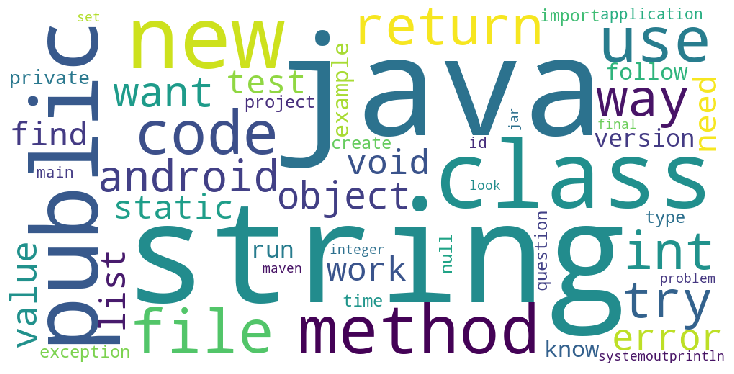

In [25]:
# wordcloud for words in the text body associated to tag: java
soup = ' '.join(df_java['lemmalist'])
wordcloud = WordCloud(background_color="white", width=1000, height=500,max_words=50, collocations=False).generate(soup)
plt.figure(figsize=(10,5),facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

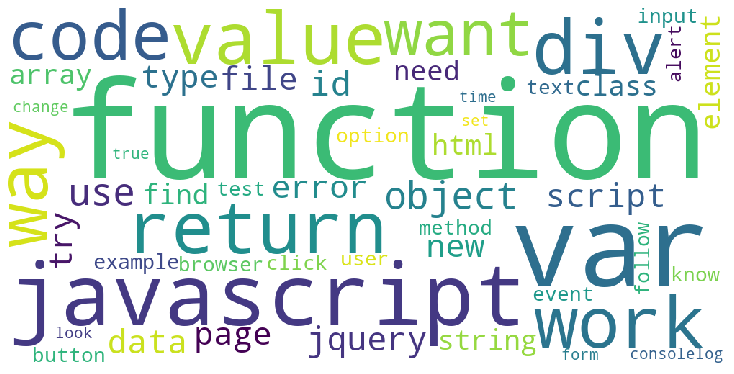

In [26]:
# wordcloud for words in the text body associated to tag: javascrpt
soup = ' '.join(df_js['lemmalist'])
wordcloud = WordCloud(background_color="white", width=1000, height=500,max_words=50, collocations=False).generate(soup)
plt.figure(figsize=(10,5),facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Final histogram

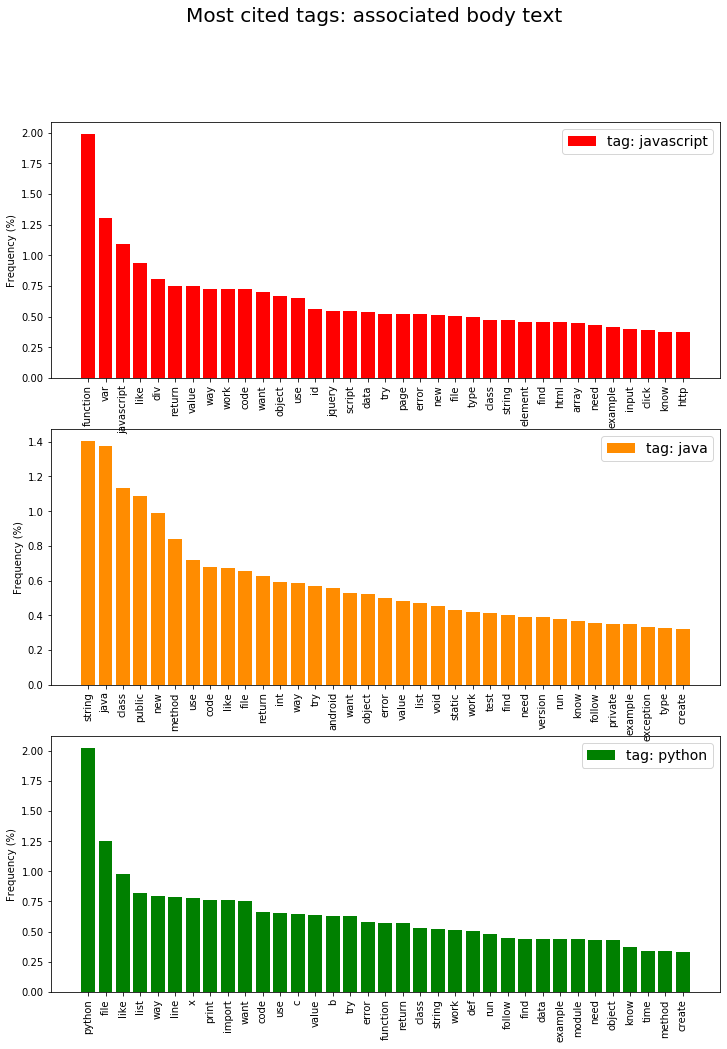

In [27]:
plt.figure(figsize=(12, 16))

plt.subplot(313)
plt.bar(df_pyfreq['word'].iloc[0:35],df_pyfreq['frequency (%)'].iloc[0:35], color = 'g', label='tag: python') #python
plt.ylabel('Frequency (%)')
plt.legend(fontsize = 14)
plt.xticks(rotation=90)

plt.subplot(312)
plt.bar(df_javafreq['word'].iloc[0:35],df_javafreq['frequency (%)'].iloc[0:35], color = 'darkorange', label='tag: java') #java
plt.ylabel('Frequency (%)')
plt.legend(fontsize = 14)
plt.xticks(rotation=90)


plt.subplot(311)
plt.bar(df_jsfreq['word'].iloc[0:35],df_jsfreq['frequency (%)'].iloc[0:35], color = 'r', label='tag: javascript') #javascript
plt.ylabel('Frequency (%)')
plt.xticks(rotation=90)
plt.legend(fontsize = 14)
plt.suptitle('Most cited tags: associated body text', fontsize = 20)
plt.show()

In [29]:
df_minimal = df_clean[['Lemma','lemmalist','tags','taglist']] #select columns to process

df_minimal.to_csv("/home/marco/Documents/OC_Machine_learning/section_5/tags_stackoverflow/data-output/stackoverflow_processed_sample.csv", index=False,na_rep='Unknown')
df_tags.to_csv("/home/marco/Documents/OC_Machine_learning/section_5/tags_stackoverflow/data-output/stackoverflow_processed_tags.csv", index=False,na_rep='Unknown')